# Random contours

In [16]:
# Import 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

import sys
sys.path.append('../')
from helpers import cm2inch, title, show_num_contours, load_datasets, normalized_contours
from melodic_contour import *
from sklearn import metrics

## Binomial random walks

What would random contours look like?
To find out we use random walks $(x_0, \dots, x_{50})$ constrained to the integers $D=\{60,  \dots, 84\}$, with binomial steps to avoid large jumps:

\begin{align}
    x_0 &\sim \text{Uniform}(D) \\
    \delta_i &\sim \text{Binomial}(n, p) \\
    x_i &= \begin{cases}
        x_{i-1} + \delta_i &\text{if $x+\delta_i \in D$} \\
        x_{i-1} - \delta_i &\text{otherwise}
    \end{cases}
\end{align}

In [3]:
def random_int_contour(N=50, n=10, p=0.5):
    contour = np.zeros((N,))
    contour[0] = np.random.randint(60,85)
    for i in range(1, N):
        step = np.random.binomial(n, p) - n*p
        step = min(max(-12, step), 12)
        if (contour[i-1] + step > 84) or (contour[i-1] + step < 60):
            contour[i] = contour[i-1] - step
        else:
            contour[i] = contour[i-1] + step
    return contour

In [137]:
def show_contours(contours, N=500):
    plt.plot(contours[:N, :].T, c='k', lw=.1, alpha=.1);
    plt.plot(contours[0,:], 'k', lw=.5)
    plt.plot(contours[1,:], 'k--', lw=.5)
    plt.plot(contours.mean(axis=0), lw=2, c='C3', label='mean')
    sns.despine()

In [61]:
contours = np.asarray([random_int_contour() for _ in range(5000)])

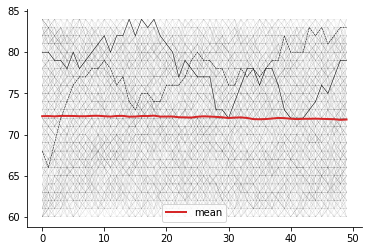

In [6]:
show_contours(contours)
plt.legend()

In [269]:
huron_optimizer = TypologyOptimizer(HuronTypology)

In [270]:
def loss_on_random_contours(optimizer, xs = np.linspace(0, 10, 50), seed=0, n_contours=1000, **kwargs):
    np.random.seed(seed)
    contours = np.asarray([random_int_contour(**kwargs) for _ in range(n_contours)])
    loss = optimizer.loss_function([Contour(c) for c in contours], ['tolerance'])
    ys = [-1*loss([x]) for x in xs]
    return contours, ys

In [278]:
HuronTypology(0).types

['descending',
 'ascending',
 'convex',
 'concave',
 'horizontal',
 'horizontal-descending',
 'horizontal-ascending',
 'descending-horizontal',
 'ascending-horizontal']

In [272]:
# contours, ys = get_loss_values()
# loss = huron_optimizer.loss_function([Contour(c) for c in contours], ['tolerance'])

# ys = [-1*loss([x]) for x in xs]

In [281]:
def show_loss(xs, ys):
    plt.plot(xs, ys)
    plt.ylabel('Entropy (bits)')
    plt.xlabel('Tolerance')
    plt.axhline(np.log2(4), ls=':', c='0.5')
    plt.text(10, np.log2(4)-.1, '$\log_2(4)$', va='top', ha='right', c='0.5')
    plt.axhline(np.log2(9), ls=':', c='0.5')
    plt.text(10, np.log2(9)-.1, '$\log_2(9)$', va='top', ha='right', c='0.5')
    sns.despine()

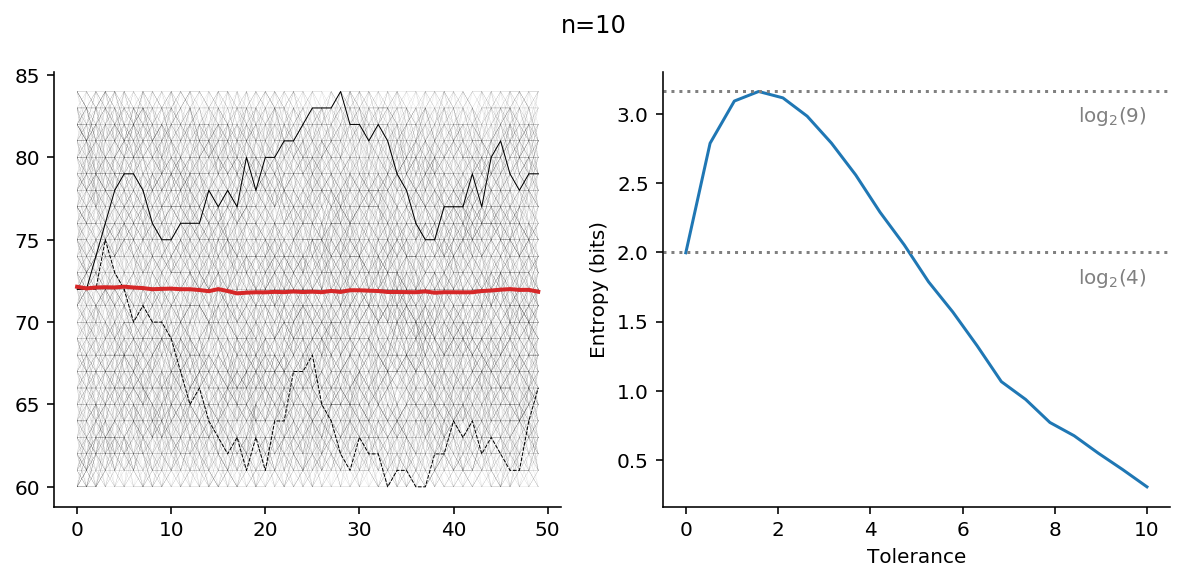

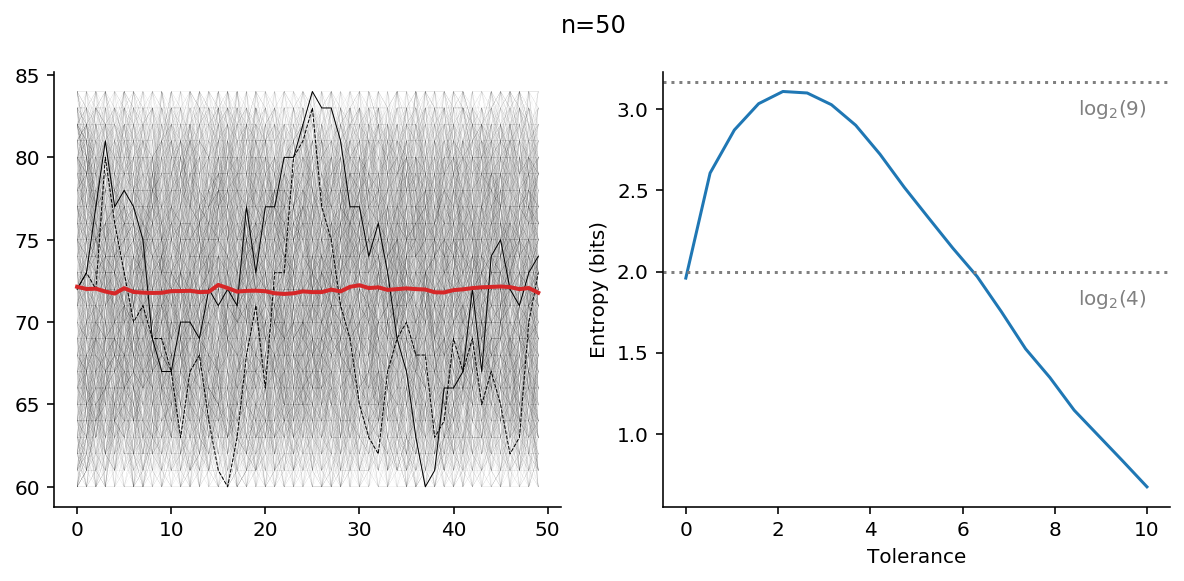

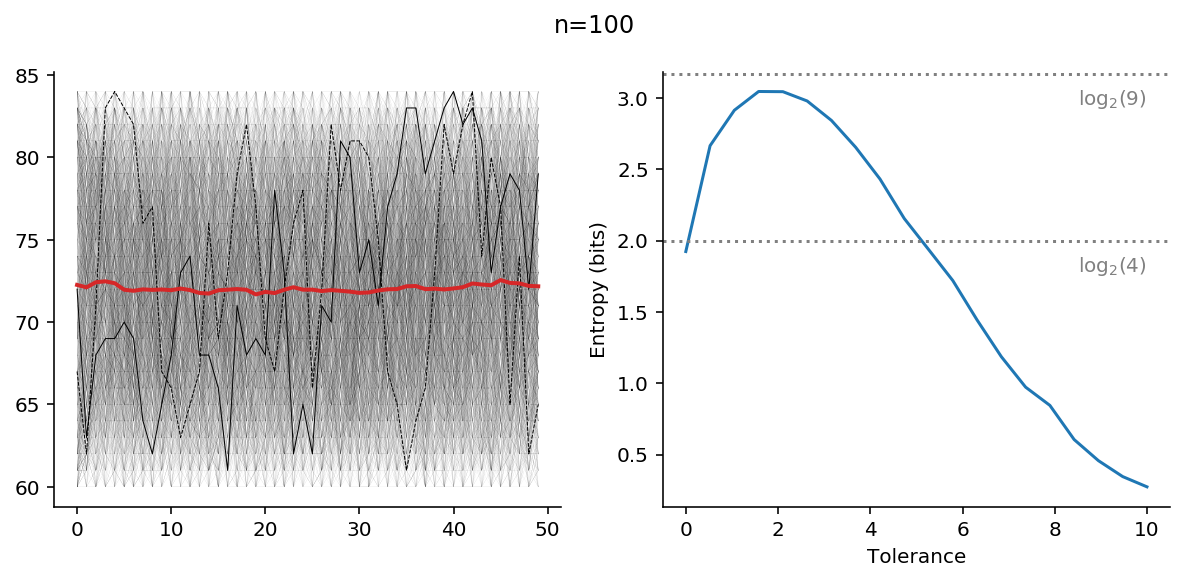

In [282]:
xs = np.linspace(0, 10, 20)

for n in [10, 50, 100]:
    opt = TypologyOptimizer(HuronTypology)
    contours, ys = loss_on_random_contours(optimizer=opt, xs=xs, n=n, seed=0)
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    show_contours(contours)
    plt.subplot(122)
    show_loss(xs, ys)
    plt.suptitle(f'n={n}')

# K-means

In [77]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [145]:
contours

array([[72., 74., 75., ..., 71., 71., 69.],
       [63., 63., 63., ..., 76., 77., 75.],
       [78., 78., 77., ..., 82., 82., 82.],
       ...,
       [71., 70., 69., ..., 67., 66., 66.],
       [68., 70., 69., ..., 79., 78., 79.],
       [73., 73., 72., ..., 61., 63., 65.]])

In [62]:
norm_contours = contours - contours.mean(axis=1)[:, np.newaxis]
norm_contours_final = contours - contours[:, -1][:, np.newaxis]

In [63]:
norm_contours_final

array([[  3.,   5.,   6., ...,   2.,   2.,   0.],
       [-12., -12., -12., ...,   1.,   2.,   0.],
       [ -4.,  -4.,  -5., ...,   0.,   0.,   0.],
       ...,
       [  5.,   4.,   3., ...,   1.,   0.,   0.],
       [-11.,  -9., -10., ...,   0.,  -1.,   0.],
       [  8.,   8.,   7., ...,  -4.,  -2.,   0.]])

In [86]:
kmeans = {}
for k in range(2, 10):
    kmeans[k] = KMeans(n_clusters=k, random_state=0).fit(norm_contours)

kmeans_final = {}
for k in range(2, 10):
    kmeans_final[k] = KMeans(n_clusters=k, random_state=0).fit(norm_contours_final)

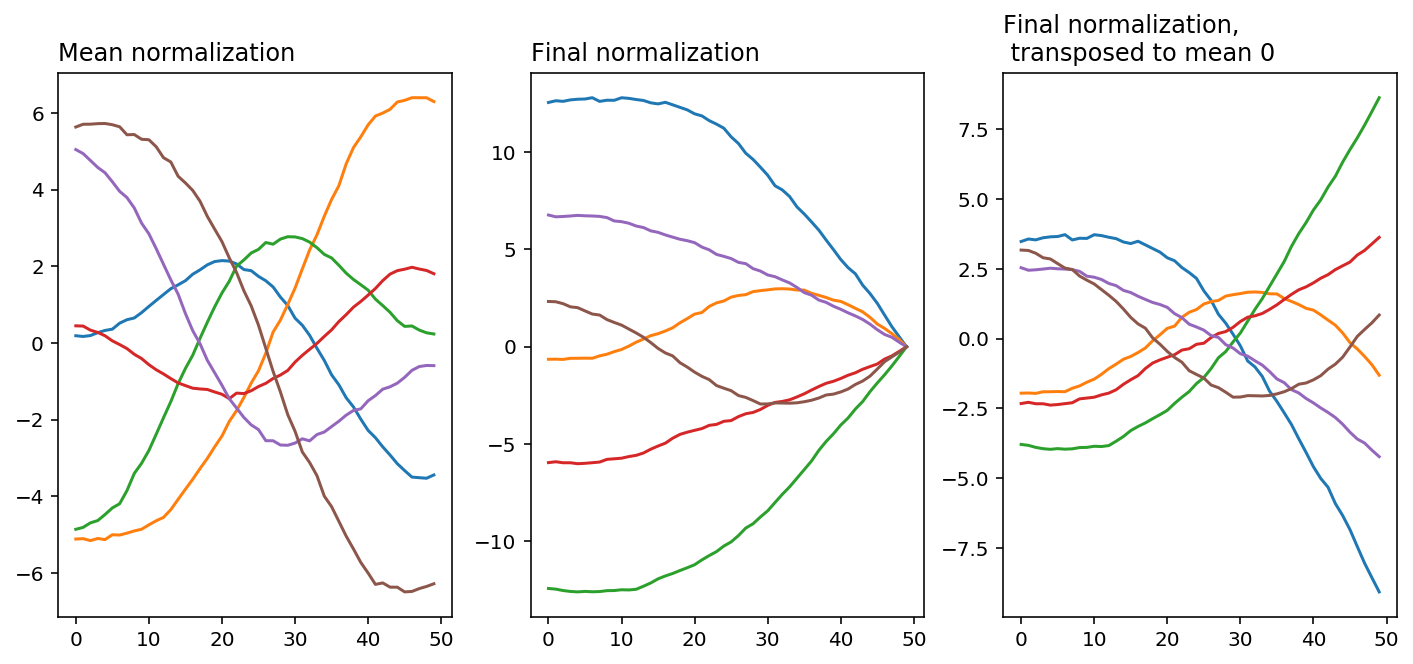

In [144]:
k = 6
plt.figure(figsize=(12,5))
plt.subplot(131)
centroids = kmeans[k].cluster_centers_
plt.plot(centroids.T)
title('Mean normalization')

plt.subplot(132)
plt.plot(kmeans_final[k].cluster_centers_.T)
title('Final normalization')

centroids_final = kmeans_final[k].cluster_centers_
plt.subplot(133)
plt.plot((centroids_final - centroids_final.mean(axis=1)[:, np.newaxis]).T)
title('Final normalization,\n transposed to mean 0')

In [147]:
import pandas as pd

In [148]:
pd.value_counts(kmeans[6].labels_)

3    1314
0    1033
4     744
2     740
1     669
5     500
dtype: int64

In [94]:
centroids_final.mean(axis=1)

array([ 6.11466262, -0.01095004, -6.19993543])

In [ ]:
def 

Text(0.5, 1.0, 'No normalization')

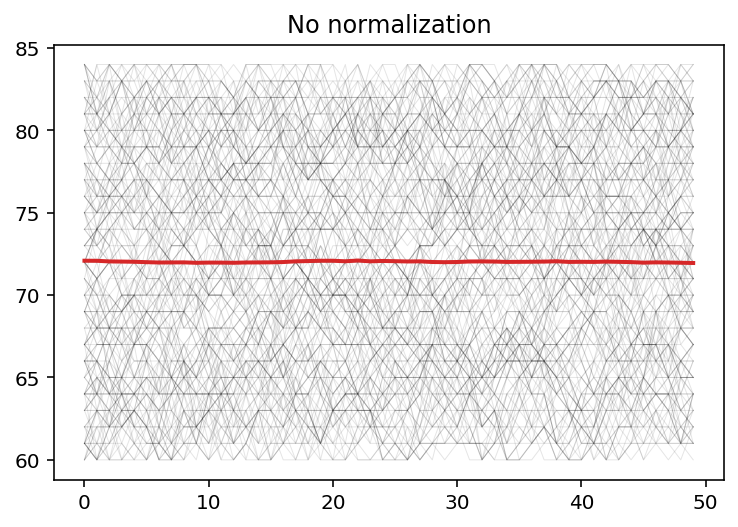

In [122]:
N=200
plt.plot(contours[:N, :].T, 'k', lw=.5, alpha=.1)
plt.plot(np.arange(50), contours.mean(axis=0), 'C3', lw=2);
plt.title('No normalization')

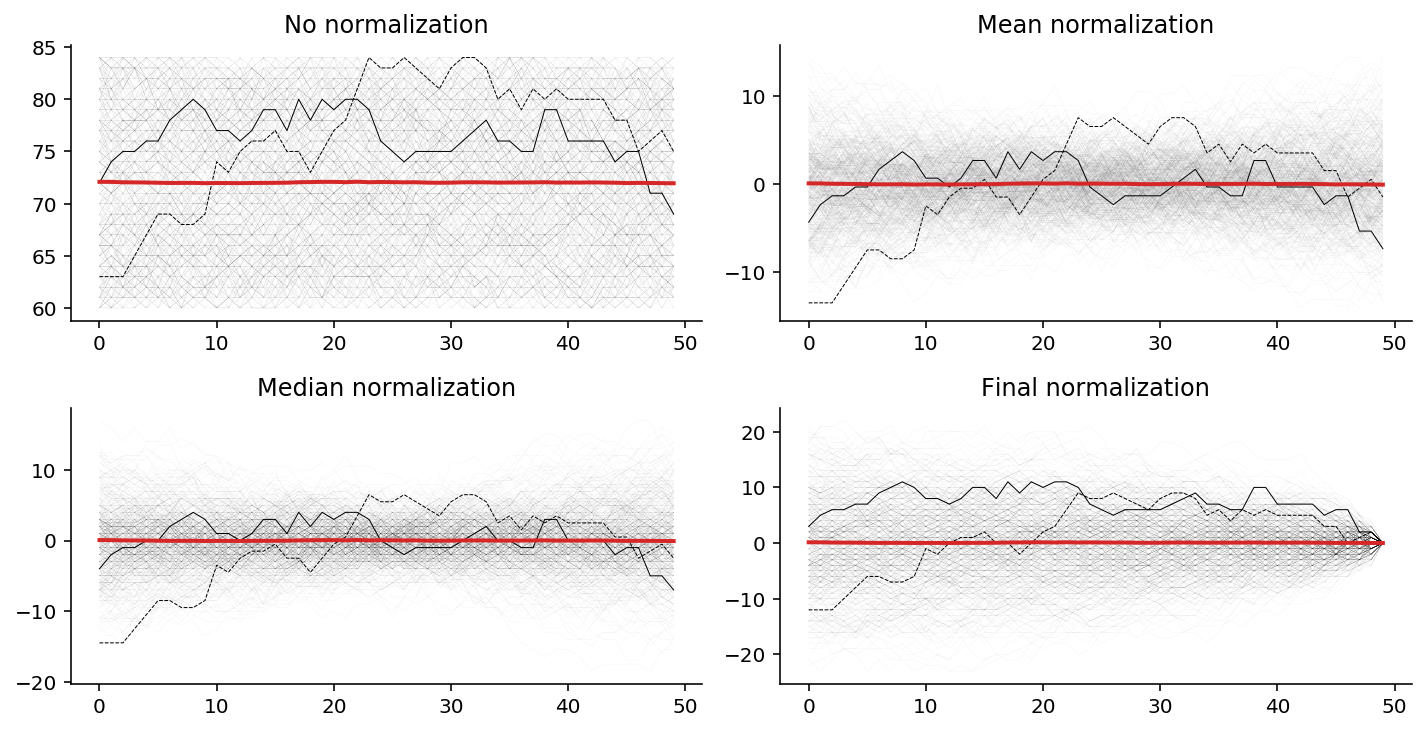

In [143]:
N=500

plt.figure(figsize=(10,10))
plt.subplot(421)
show_contours(contours, N=N)
plt.title('No normalization')

plt.subplot(422)
C = contours - contours.mean(axis=1)[:, np.newaxis]
show_contours(C, N=N)
plt.title('Mean normalization')


plt.subplot(423)
C = contours - np.median(contours, axis=1)[:, np.newaxis]
show_contours(C, N=N)
plt.title('Median normalization')

plt.subplot(424)
C = contours - contours[:, -1][:, np.newaxis]
show_contours(C, N=N)
plt.title('Final normalization')


plt.tight_layout()

In [126]:
contours.

AttributeError: 'numpy.ndarray' object has no attribute 'median'

Text(0.5, 1.0, 'Median normalization')

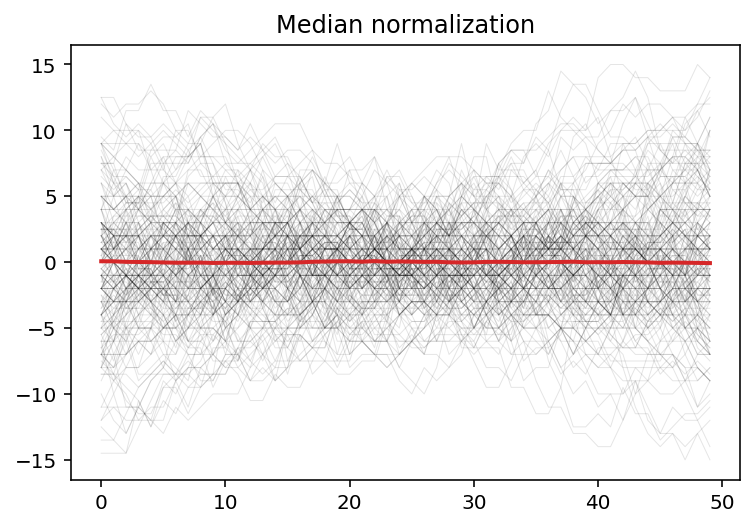

In [128]:
N=200
C = contours - np.median(contours, axis=1)[:, np.newaxis]
plt.plot(C[:N, :].T, 'k', lw=.5, alpha=.1)
plt.plot(np.arange(50), C.mean(axis=0), 'C3', lw=2);
plt.title('Median normalization')

In [78]:
def show_pca(contours):
    pca = PCA(n_components=6)
    transformed_contours = pca.fit_transform(contours)
    xs = np.linspace(0, 1, 50)
    
    components = []
    for i in range(len(pca.components_)):
        comp = pca.components_[i]
        factor = -1 if comp[0] < comp[-1] else 1
        components.append(factor * comp)
        
    plt.plot(xs, components[0], c='k', lw=1, label=f'$C_1$ ({pca.explained_variance_ratio_[0]:.0%})')
    plt.plot(xs, components[1], c='C3', lw=1, label=f'$C_2$ ({pca.explained_variance_ratio_[1]:.0%})')
    plt.plot(xs, components[2], c='C0', lw=1, label=f'$C_3$ ({pca.explained_variance_ratio_[2]:.0%})')


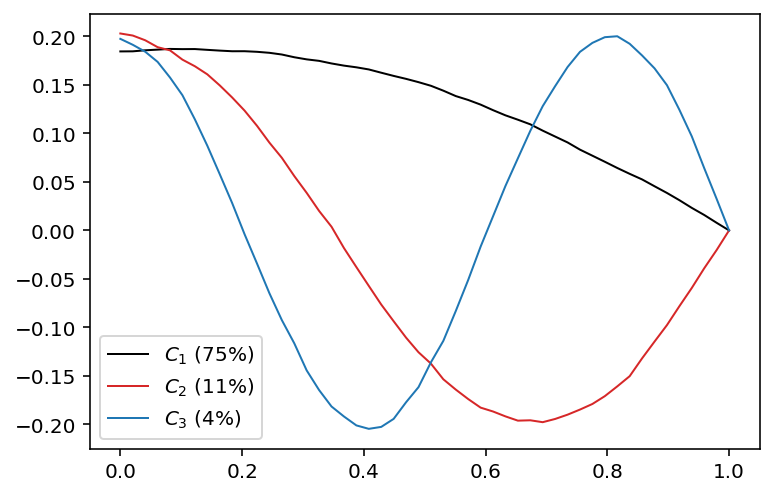

In [80]:
show_pca(norm_contours_final)
plt.legend()

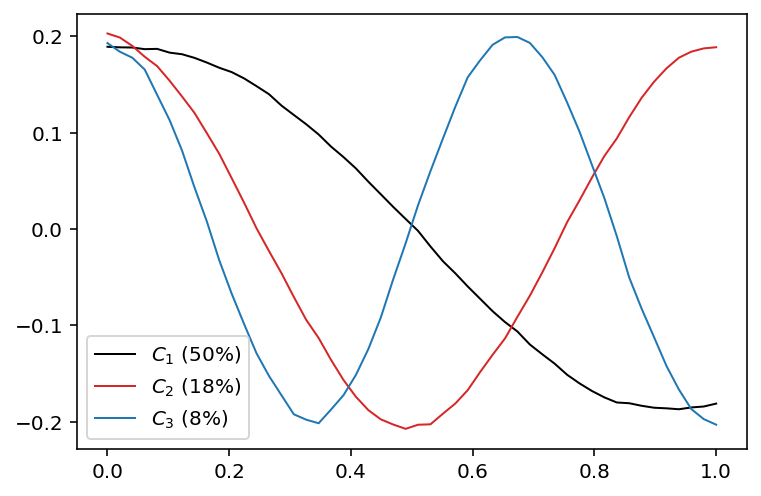

In [81]:
show_pca(norm_contours)
plt.legend()

In [42]:
plt.plot(kmeans[2].cluster_centers_ - kmeans[2].cluster_centers_.mean(axis=1)[:, np.newaxis].T)

ValueError: operands could not be broadcast together with shapes (2,50) (1,2) 

## Part

In [355]:
def loss_on_parts(optimizer, xs = np.linspace(0, 10, 50), seed=0, n_contours=1000, scale=2, **kwargs):
    np.random.seed(seed)
    contours = np.random.normal(loc=60, scale=scale, size=(n_contours, 3))
    loss = optimizer.loss_function([Contour(c) for c in contours], ['tolerance'])
    ys = [-1*loss([x]) for x in xs]
    return contours, ys

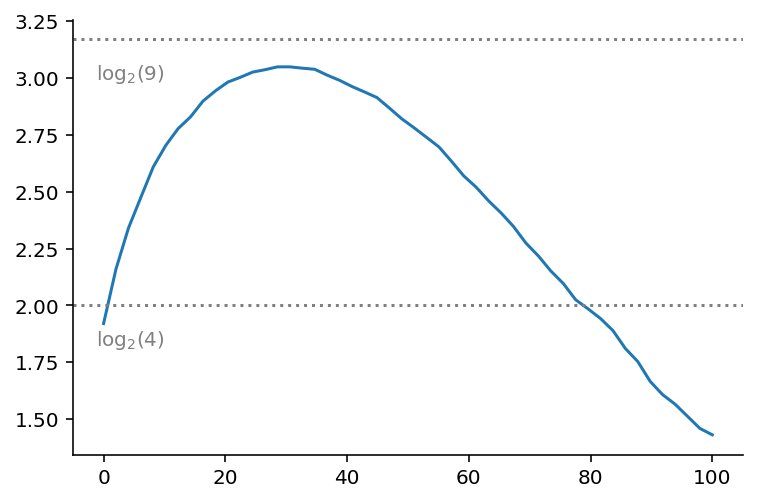

In [357]:
opt = TypologyOptimizer(HuronTypology)
xs = np.linspace(0, 100, 50)
_, ys = loss_on_parts(optimizer=opt, xs=xs, scale=50)
plt.plot(xs, ys)
plt.axhline(np.log2(4), ls=':', c='0.5')
plt.text(10, np.log2(4)-.1, '$\log_2(4)$', va='top', ha='right', c='0.5')
plt.axhline(np.log2(9), ls=':', c='0.5')
plt.text(10, np.log2(9)-.1, '$\log_2(9)$', va='top', ha='right', c='0.5')
sns.despine()

In [335]:
dfs, contours = load_datasets()

In [337]:
50/3

16.666666666666668

In [348]:
contours['erk'].std(axis=1).mean()

2.4281452686639753

In [301]:
means = np.random.normal(loc=60, scale=5, size=(3,1000))

In [303]:
typ = HuronTypology(tolerance=.5)

In [306]:
means[:, 0]

array([62.5842887 , 66.91232679, 64.92653867])

In [311]:
typ.classify(Contour([0,-1,-1]))

'descending-horizontal'

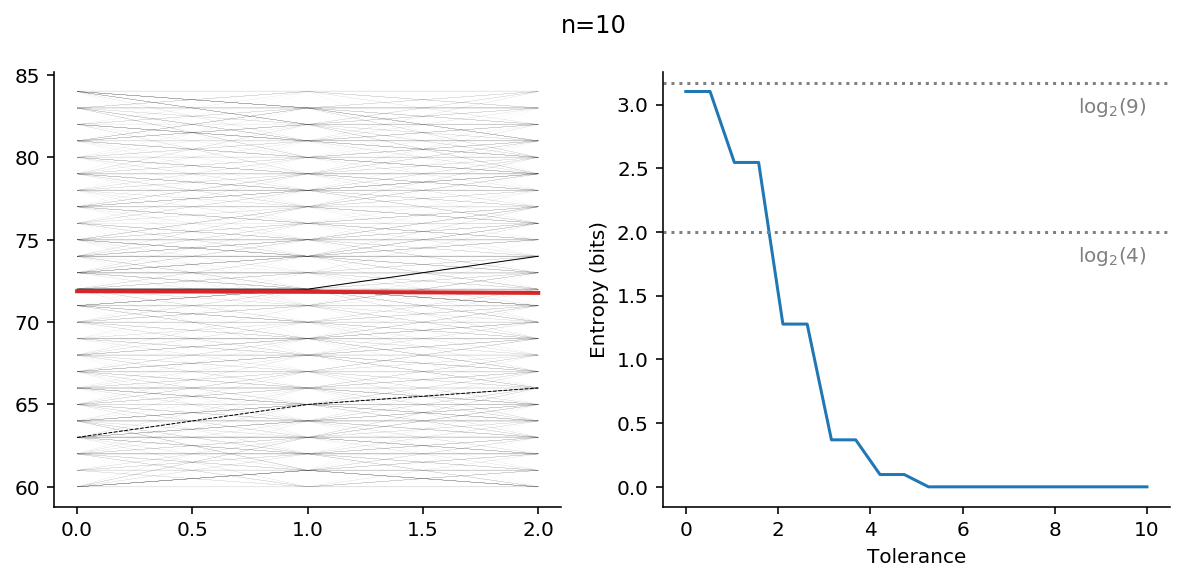

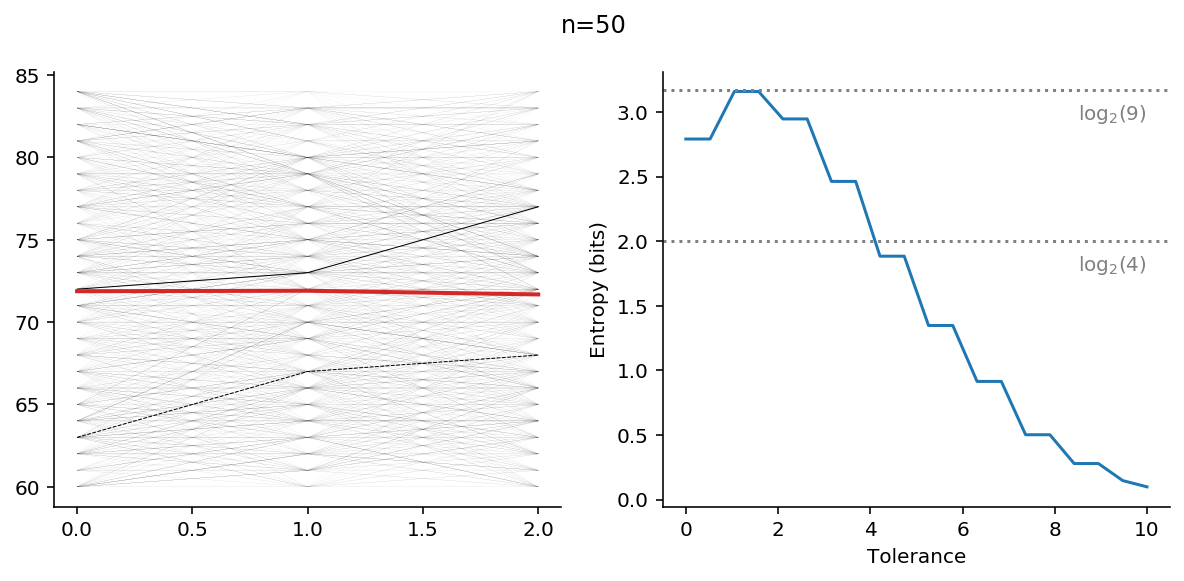

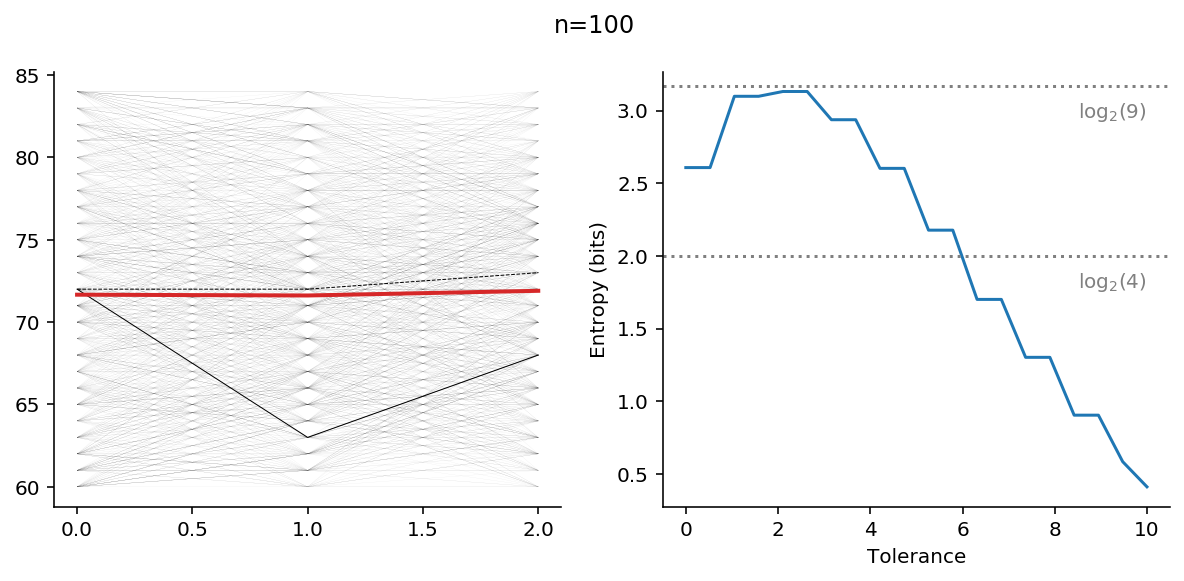

In [288]:
xs = np.linspace(0, 10, 20)

for n in [10, 50, 100]:
    opt = TypologyOptimizer(HuronTypology)
    contours, ys = loss_on_random_contours(optimizer=opt, xs=xs, n=n, seed=0, N=3)
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    show_contours(contours)
    plt.subplot(122)
    show_loss(xs, ys)
    plt.suptitle(f'n={n}')